In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from data_preprocessing import create_segmentation_datasets

2025-08-09 23:03:58.409135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-09 23:03:59.128672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
image_dir = '/home/featurize/data/segmentation_dataset/images'
mask_dir = '/home/featurize/data/segmentation_dataset/masks'

dataset_train, dataset_val, dataset_test = create_segmentation_datasets(image_dir=image_dir, mask_dir=mask_dir, batch_size=24, val_split=0.2, test_split=0.1)

for imgs, masks in dataset_train.take(1):
    print('Train batch images:', imgs.shape, 'masks:', masks.shape)
for imgs, masks in dataset_val.take(1):
    print('Val batch images:', imgs.shape, 'masks:', masks.shape)
for imgs, masks in dataset_test.take(1):
    print('Test batch images:', imgs.shape, 'masks:', masks.shape)

Training samples: 4634, validation samples: 1324, test samples: 662


2025-08-09 23:03:59.942945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-09 23:03:59.947727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-09 23:03:59.947906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)
Val batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)
Test batch images: (24, 384, 508, 3) masks: (24, 384, 508, 1)


In [4]:
# import tensorflow as tf
# import numpy as np
# from collections import Counter

# def count_classes_in_dataset(dataset):
#     total_counter = Counter()

#     for batch in dataset:
#         images, masks = batch
#         flat_masks = tf.reshape(masks, [-1])
#         result = tf.unique_with_counts(flat_masks)
#         unique_vals = result.y
#         counts = result.count

#         for val, count in zip(unique_vals.numpy(), counts.numpy()):
#             total_counter[int(val)] += int(count)

#     print("\n Dataset 中的类别总分布：")
#     for cls in sorted(total_counter.keys()):
#         print(f"类 {cls}: {total_counter[cls]} 像素")

#     return total_counter

# # 示例调用
# count_classes_in_dataset(dataset_train)

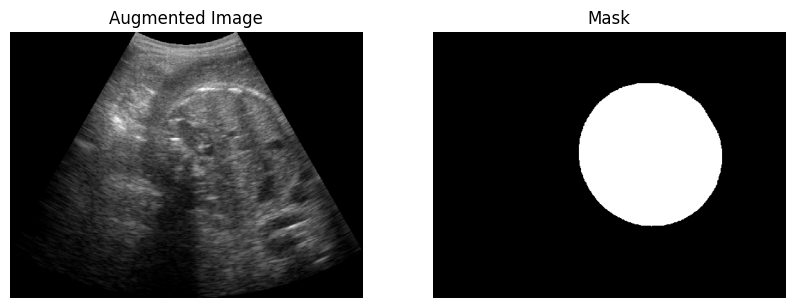

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, mask_batch in dataset_train.take(1):
    img = img_batch[0].numpy()
    mask = mask_batch[0].numpy()

    # 1. 将图像从 [-1, 1] 转回 [0, 1] 浮点图像
    img_display = (img + 1.0) / 2.0
    img_display = np.clip(img_display, 0.0, 1.0)

    # 2. 将 mask squeeze，转换为 uint8，用于灰度显示
    mask_display = np.squeeze(mask).astype(np.uint8)

    # 可视化
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_display, cmap='gray', vmin=0.0, vmax=1.0)  # 显式指定范围
    plt.axis('off')
    plt.title("Augmented Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_display, cmap='gray', vmin=0, vmax=1)  # 确保 0=黑，1=白
    plt.axis('off')
    plt.title("Mask")

    plt.show()


In [6]:
from model_test import DeepLabV3Plus

In [7]:
model = DeepLabV3Plus(img_height=384, img_width=508, nclasses=2)
model.summary()

*** Building DeepLabV3+ (Xception backbone) ***
Loaded Xception weights from: /home/featurize/data/xception.h5
*** Output_Shape => (None, 384, 508, 2) ***
Model: "DeepLabV3_Plus_Xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 508, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 191, 253, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 191, 253, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                    

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(num_classes=2, name='train_iou')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
val_iou = MeanIoU(num_classes=2, name='val_iou')

# ===============================
# 3. 单步训练与验证
# ===============================
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

@tf.function
def val_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_object(labels, predictions)

    val_loss(loss)
    val_accuracy(labels, predictions)
    val_iou(labels, predictions)

# ===============================
# 4. 训练循环
# ===============================
EPOCHS = 50
train_loss_list, train_acc_list, train_iou_list = [], [], []
val_loss_list, val_acc_list, val_iou_list = [], [], []

for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_accuracy.reset_state()
    train_iou.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()
    val_iou.reset_state()

    for images, labels in dataset_train:
        train_step(images, labels)

    for images, labels in dataset_val:
        val_step(images, labels)

    train_loss_list.append(train_loss.result().numpy())
    train_acc_list.append(train_accuracy.result().numpy())
    train_iou_list.append(train_iou.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    val_acc_list.append(val_accuracy.result().numpy())
    val_iou_list.append(val_iou.result().numpy())

    print(f"Epoch {epoch+1:02d}: "
          f"Loss={train_loss.result():.4f}, Acc={train_accuracy.result():.4f}, IoU={train_iou.result():.4f} | "
          f"Val Loss={val_loss.result():.4f}, Val Acc={val_accuracy.result():.4f}, Val IoU={val_iou.result():.4f}")

2025-08-09 23:04:12.895530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-08-09 23:04:22.677865: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2025-08-09 23:05:04.293911: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5f2be11640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-09 23:05:04.294135: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-08-09 23:05:04.298408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-09 23:05:04.429467: I ./tensorflow/compiler/jit/device_compiler.

Epoch 01: Loss=0.1765, Acc=0.9280, IoU=0.7428 | Val Loss=0.3752, Val Acc=0.8739, Val IoU=0.4369
Epoch 02: Loss=0.0657, Acc=0.9741, IoU=0.8920 | Val Loss=0.3293, Val Acc=0.8739, Val IoU=0.4369
Epoch 03: Loss=0.0431, Acc=0.9827, IoU=0.9262 | Val Loss=0.2790, Val Acc=0.8739, Val IoU=0.4371
Epoch 04: Loss=0.0351, Acc=0.9859, IoU=0.9393 | Val Loss=0.0586, Val Acc=0.9773, Val IoU=0.9039
Epoch 05: Loss=0.0293, Acc=0.9882, IoU=0.9486 | Val Loss=0.0371, Val Acc=0.9845, Val IoU=0.9317
Epoch 06: Loss=0.0252, Acc=0.9896, IoU=0.9547 | Val Loss=0.0420, Val Acc=0.9833, Val IoU=0.9257
Epoch 07: Loss=0.0225, Acc=0.9907, IoU=0.9593 | Val Loss=0.0308, Val Acc=0.9873, Val IoU=0.9437
Epoch 08: Loss=0.0202, Acc=0.9916, IoU=0.9632 | Val Loss=0.0324, Val Acc=0.9871, Val IoU=0.9421
Epoch 09: Loss=0.0184, Acc=0.9923, IoU=0.9663 | Val Loss=0.0334, Val Acc=0.9866, Val IoU=0.9404
Epoch 10: Loss=0.0174, Acc=0.9927, IoU=0.9681 | Val Loss=0.0397, Val Acc=0.9848, Val IoU=0.9315
Epoch 11: Loss=0.0169, Acc=0.9929, IoU=0

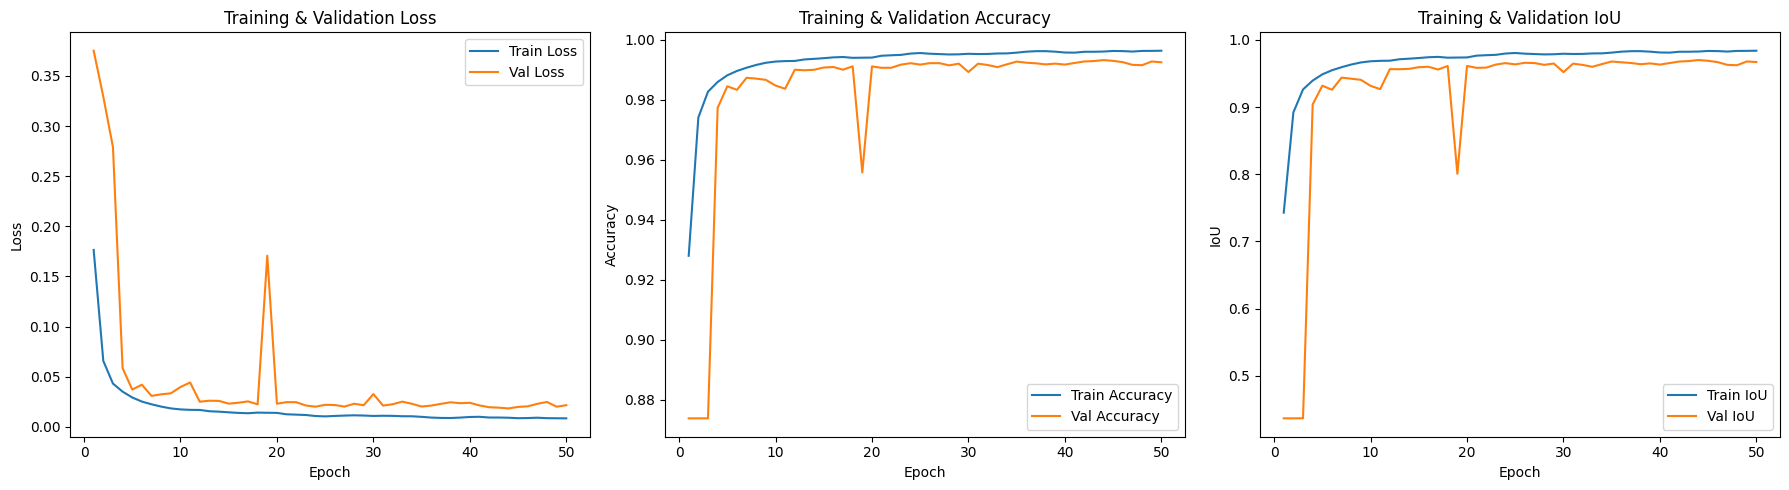

In [10]:
# ========= 训练曲线可视化 ========= #

epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# IoU
plt.subplot(1, 3, 3)
plt.plot(epochs, train_iou_list, label='Train IoU')
plt.plot(epochs, val_iou_list, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training & Validation IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
model.save_weights('my_model_weights.weights.h5')
model.save('my_model_full.h5')

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 694ms/step


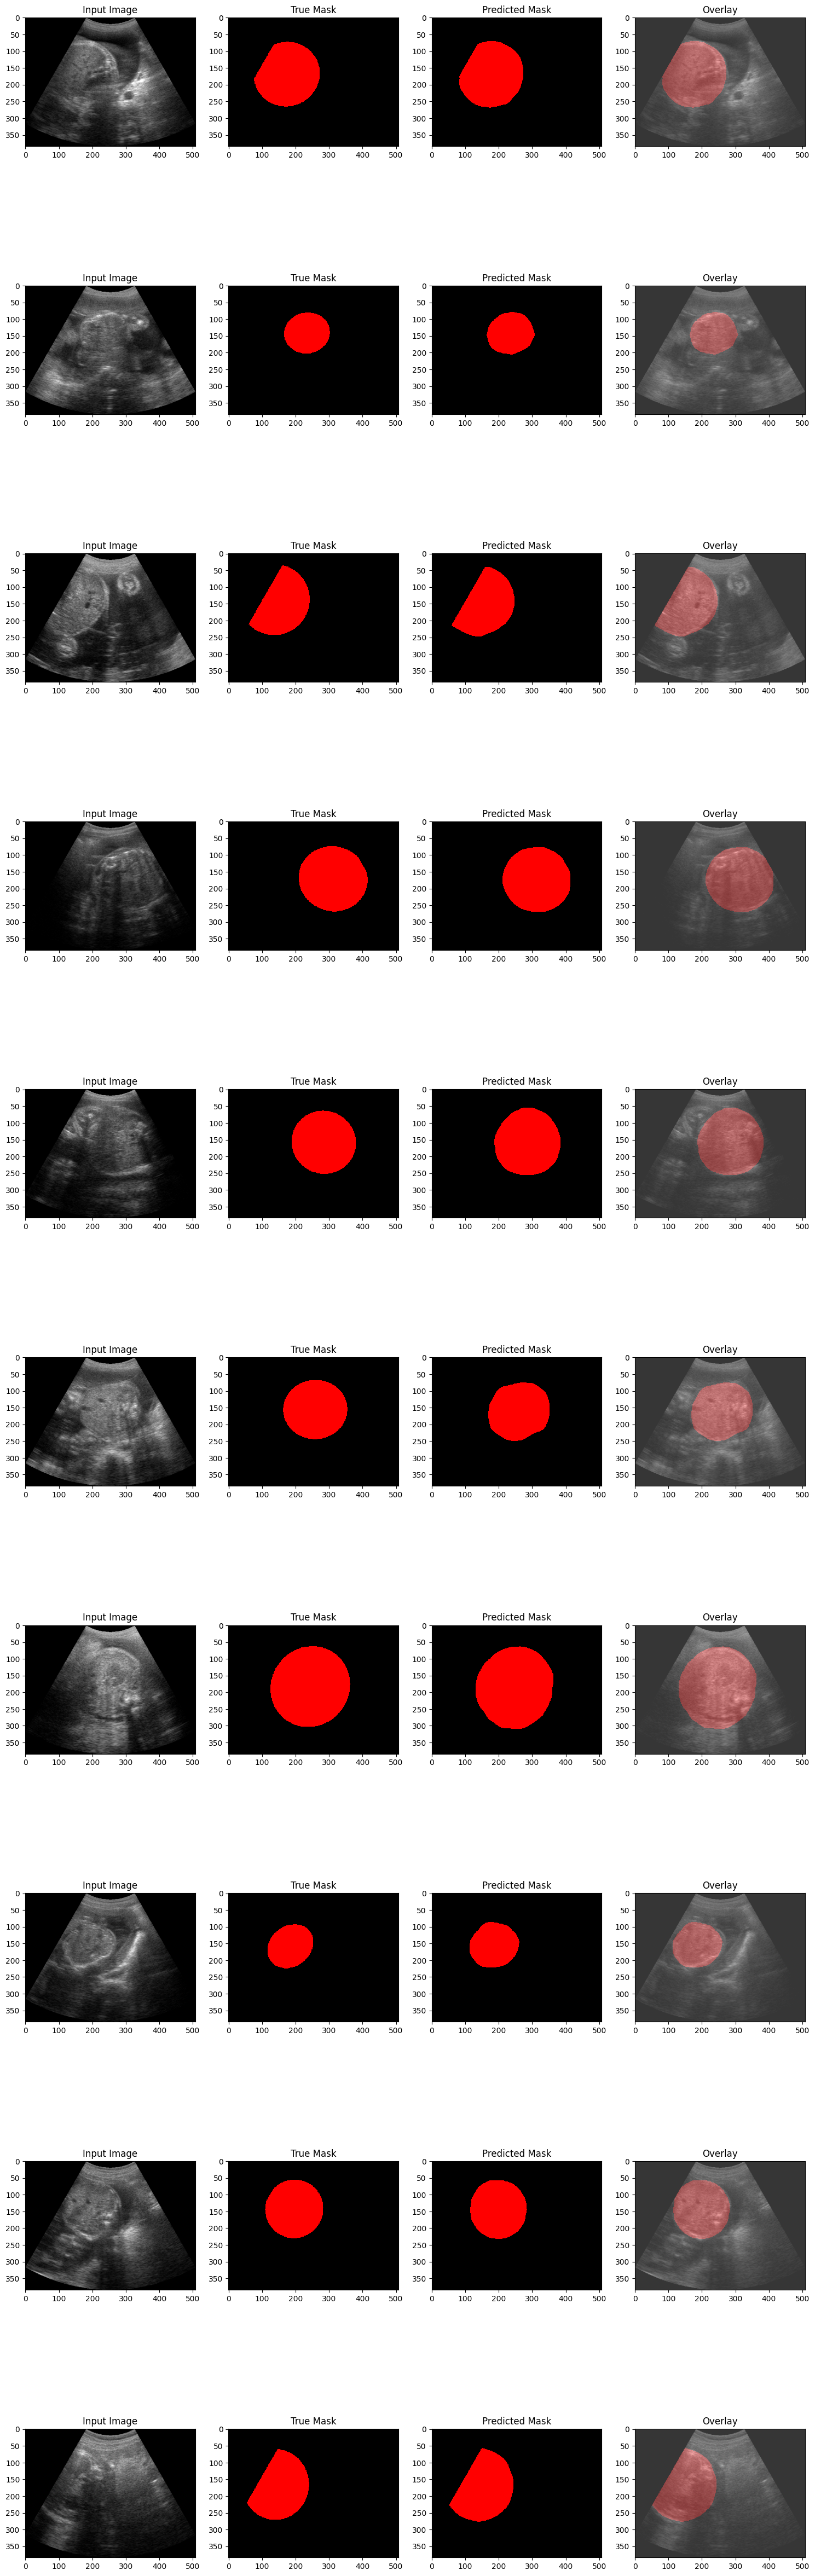

 Evaluation Metrics
Mean IoU   : 0.965603
Accuracy   : 0.99174255
Precision  : 0.9580408
Recall     : 0.9811311


In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall
import pickle

# with open("weights_tf10_compatible.pkl", "rb") as f:
#     weights = pickle.load(f)
# models.set_weights(weights)
model.load_weights('my_model_weights.weights.h5')


miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()


cmap = ListedColormap(['black', 'green', 'red'])

#  每轮展示多少图像
num = 10

#  从验证集取一个 batch
for image, mask in dataset_test.take(1):
    # 模型预测（logits -> 类别索引）
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1) for broadcasting

    # 可视化结果
    fig = plt.figure(figsize=(15, num * 5))

    for i in range(num):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

        plt.subplot(num, 4, i * 4 + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.title("Input Image")

        plt.subplot(num, 4, i * 4 + 2)
        plt.imshow(true_mask, cmap=cmap, interpolation='nearest')
        plt.title("True Mask")

        plt.subplot(num, 4, i * 4 + 3)
        plt.imshow(pred, cmap=cmap, interpolation='nearest')
        plt.title("Predicted Mask")

        plt.subplot(num, 4, i * 4 + 4)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]), alpha=0.7)
        plt.imshow(pred, cmap=cmap, alpha=0.3, interpolation='nearest')
        plt.title("Overlay")

    plt.tight_layout()
    plt.show()

print(" Evaluation Metrics")
print("Mean IoU   :", miou_metric.result().numpy())
print("Accuracy   :", accuracy_metric.result().numpy())
print("Precision  :", precision_metric.result().numpy())
print("Recall     :", recall_metric.result().numpy())


In [13]:
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

cmap = ListedColormap(['black', 'green', 'red'])

for image, mask in dataset_test:
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1)

    for i in range(image.shape[0]):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

print("\n Evaluation Metrics on Test Set")
print("Mean IoU   :", round(miou_metric.result().numpy(), 4))
print("Accuracy   :", round(accuracy_metric.result().numpy(), 4))
print("Precision  :", round(precision_metric.result().numpy(), 4))
print("Recall     :", round(recall_metric.result().numpy(), 4))


1/1 [==============================] - 2s 2s/step

 Evaluation Metrics on Test Set
Mean IoU   : 0.9681
Accuracy   : 0.9927
Precision  : 0.9676
Recall     : 0.9753


In [14]:
import tensorflow as tf
from matplotlib.colors import ListedColormap
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall
import numpy as np

# with open("weights_tf10_compatible.pkl", "rb") as f:
#     weights = pickle.load(f)
model.load_weights('my_model_weights.weights.h5')

miou_metric = MeanIoU(num_classes=2)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

num_classes = 2
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

cmap = ListedColormap(['black', 'green', 'red'])

for image, mask in dataset_test:
    logits = model.predict(image)
    pred_mask = tf.argmax(logits, axis=-1)           # (B, H, W)
    pred_mask = pred_mask[..., tf.newaxis]           # (B, H, W, 1)

    for i in range(image.shape[0]):
        if mask[i].shape[-1] > 1:
            true_mask = tf.argmax(mask[i], axis=-1)
        else:
            true_mask = tf.squeeze(mask[i])
        true_mask = tf.cast(true_mask, tf.int32)

        pred = tf.squeeze(pred_mask[i])
        pred = tf.cast(pred, tf.int32)

        miou_metric.update_state(true_mask, pred)
        accuracy_metric.update_state(true_mask, pred)
        precision_metric.update_state(true_mask, pred)
        recall_metric.update_state(true_mask, pred)

        y_true = tf.reshape(true_mask, [-1])
        y_pred = tf.reshape(pred, [-1])
        cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()
        confusion_matrix += cm

dice_per_class = []
for i in range(num_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP
    FN = np.sum(confusion_matrix[i, :]) - TP
    denom = 2 * TP + FP + FN
    dice = 2 * TP / denom if denom > 0 else 0.0
    dice_per_class.append(dice)

mean_dice = np.mean(dice_per_class)

print("\n Evaluation Metrics on Test Set")
print("Mean IoU   :", round(miou_metric.result().numpy(), 4))
print("Accuracy   :", round(accuracy_metric.result().numpy(), 4))
print("Precision  :", round(precision_metric.result().numpy(), 4))
print("Recall     :", round(recall_metric.result().numpy(), 4))
print("Dice Coef. :", [f"Class {i}: {round(d, 4)}" for i, d in enumerate(dice_per_class)])
print("Mean Dice  :", round(mean_dice, 4))

1/1 [==============================] - 0s 41ms/step

 Evaluation Metrics on Test Set
Mean IoU   : 0.9681
Accuracy   : 0.9927
Precision  : 0.9676
Recall     : 0.9753
Dice Coef. : ['Class 0: 0.9958', 'Class 1: 0.9714']
Mean Dice  : 0.9836
